# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import random
import numpy as np
import copy
from collections import namedtuple, deque
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
states.shape

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


(2, 24)

In [5]:
brain.vector_action_space_size

2

### 3. Define Model Actor and Critic

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.state_size = state_size
        self.bn = nn.BatchNorm1d(state_size)
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 =nn.BatchNorm1d(fc1_units)
        self.dr1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 =nn.BatchNorm1d(fc2_units)
        self.dr2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if len(state) == self.state_size:
            state= state.unsqueeze(0)
        #state = self.bn(state)
        x = F.relu(self.fc1(state))
        #x= self.bn1(x)
        x= self.dr1(x)
        x = F.relu(self.fc2(x))
        #x=self.bn2(x)
        #x= self.dr2(x)
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256,fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.bn = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 =nn.BatchNorm1d(fcs1_units)
        self.dr1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(fcs1_units+action_size+state_size, fc2_units)
        self.dr2 = nn.Dropout(0.2)
        self.bn2 =nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units+action_size+state_size, fc3_units)
        self.dr3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #state = self.bn(state)
        xs = F.relu(self.fcs1(state))
        #xs = self.dr1(xs)
        #xs =self.bn1(xs)
        x = torch.cat((xs, action,state), dim=1)
        #x= self.dr2(x)
        
        x = F.relu(self.fc2(x))
        x =self.bn2(x)
        x = torch.cat((x,action,state),dim=1)
        #x= self.dr3(x)
        x = F.relu(self.fc3(x))
        #x = torch.cat((x,action),dim=1)
        return torch.tanh(self.fc4(x))


### 4. Define Agent and hyperparameters

In [7]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0.0001        # L2 weight decay
WEIGHT_DECAY = 0        # L2 weight decay
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():
    def __init__(self, state_size, action_size,  random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            n_agents: number of agents it will control in the environment
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size,  seed=random_seed).to(device)
        self.actor_target = Actor(state_size, action_size,  seed=random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, seed=random_seed).to(device)
        self.critic_target = Critic(state_size, action_size,  seed=random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC,weight_decay=WEIGHT_DECAY)
        # self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.current_step = 0 

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.current_step+=1
        for i in range (len(states)):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=False):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        actions = np.zeros((num_agents, self.action_size))
        with torch.no_grad():
            for i,state in enumerate(states):
                actions[i]=self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions += [self.noise.sample() for _ in range(num_agents)]
        return actions

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    @property
    def device(self):
        return device

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = np.random.seed(seed)
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = np.random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 5. Initialise Agent

In [8]:
seed=0
agent = Agent(state_size=state_size, action_size=action_size,random_seed=seed)

### 6. Define algorithm

In [9]:
def maddpg( max_t = 1000, window_size=100, score_threshold=1, 
         print_interval=100, epochs=5000):

    scores_deque = deque(maxlen=window_size) 
    local_scores_deque = deque(maxlen=window_size//2)
    scores = []
    prev_average_score = 0        
    print("Training on {} started...".format(agent.device))
    for i_episode in range(1, epochs+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        episode_scores = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=[reward*10 if reward <0 else reward  for reward in rewards], next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break
            #score = np.max(episode_score)

        episode_score = np.max(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        local_scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)
        max_local_score= np.mean(local_scores_deque)

        if i_episode % (print_interval//2) == 0:
            print('\rEpisode: {}\tAverage Score: {:.3f}\tlocal average Score: {:.3f}\tCurrent Score: {:.3f}\tScores : {:.3f} {:.3f}'.format(i_episode, average_score,max_local_score, episode_score , *episode_scores))
        #if i_episode % print_interval == 0:
        #    print('\rEpisode: {}\tAverage Score: {:.3f}\tlocal average Score: {:.3f}\tCurrent Score: {:.3f}'.format(i_episode, average_score,max_local_score, episode_score))
        if average_score>prev_average_score+5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.3f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
    np.save('scores_1.npy', scores)
    return scores

#### Run training

In [10]:
scores = maddpg()

Training on cuda:0 started...
Episode: 50	Average Score: 0.002	local average Score: 0.002	Current Score: 0.000	Scores : -0.010 0.000
Episode: 100	Average Score: 0.001	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 150	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 200	Average Score: 0.002	local average Score: 0.004	Current Score: 0.000	Scores : -0.010 0.000
Episode: 250	Average Score: 0.002	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 300	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 350	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : 0.000 -0.010
Episode: 400	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 450	Average Score: 0.000	local average Score: 0.000	Current Score: 0.000	Scores : -0.010 0.000
Episode: 500	Average Score: 0.000	l

### 7. Plot results

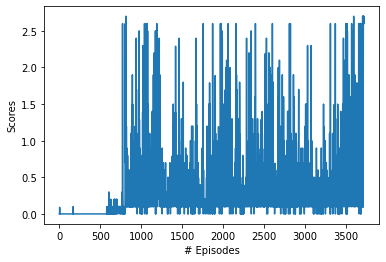

In [11]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('scores_plot_1_score.png')
plt.show()

### 7. Run Inference mode

In [12]:
agent = Agent(state_size=state_size, action_size=action_size,random_seed=0)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

<All keys matched successfully>

In [13]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
step = 0
while step<1000:
    step+=1
    actions = agent.act(states)                      # select an action
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rewards = env_info.rewards                   # get the reward
    done = env_info.local_done                  # see if episode has finished
    scores += rewards                                # update the score
    states = next_states                             # roll over the state to next time step
    if np.any(dones):
        break
    
print("Score: {}".format(np.mean(scores)))

Score: 2.650000039488077


In [14]:
env.close()